## Setup and Imports

# Gaussian Mixture Model Implementation using EM Algorithm

## Purpose
This notebook contains implementation of EM (Expectation-Maximization) algorithm to estimate the parameters of Gaussian Mixture Model, that fits the given data

## Key Features

- **EM algorithm**
- **Multiple Initialization Strategies**: Random, K-means based, and percentile-based initialization methods
- **Model Selection using BIC**: Calculating optimal parameter number using BIC
- **Comparison with scikit-learn**: Validation against sklearn.mixture.GaussianMixture
- **Experiments with synthetic data and real-world data**
- **Log-likelihood score**: Calculates log-likelihood of the estimated model, to compare it to other models

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from math import sqrt, log, exp, pi
import random

In [13]:
# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

The Gaussian class represents a single Gaussian (normal) distribution. It stores the mean (mu) and standard deviation (sigma) of the distribution.

Functions
* **`__init__(self, mu, sigma)`**: Initializes a Gaussian distribution with a given mean and standard deviation
* **`pdf(self, datum)`**: Calculates the Probability Density Function (PDF) value for a single data point
* **`pdf_array(self, data)`**: Calculates the PDF values for an array of data points
* **`__repr__(self)`**: Provides a string representation of the Gaussian object, showing its mean and standard deviation

In [14]:
class Gaussian:
  def __init__(self, mu, sigma):
    self.mu = mu # Mean
    self.sigma = sigma # Standard deviation

  # PDF
  def pdf(self, datum):
    u = (datum - self.mu) / abs(self.sigma)
    y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
    return y

  def pdf_array(self, data):
    return np.array([self.pdf(datum) for datum in data])

  def __repr__(self):
    return "Gaussian({0:4.6}, {1:4.6})".format(self.mu, self.sigma)

## EM Algorithm for Gaussian Mixture Models

The Expectation-Maximization (EM) algorithm is an iterative method for finding maximum likelihood estimates of parameters in statistical models with latent variables.

### Algorithm Steps:

1. **Initialization**: Set initial estimates for means, variances, and mixture weights
   - Critical step as EM converges to local optima
   - Multiple initialization strategies improve chances of finding global optimum

2. **E-step (Expectation)**: Calculate responsibilities γᵢⱼ for each data point
   - γᵢⱼ represents the probability that data point j belongs to component i
   - Formula: γᵢⱼ = (wᵢ · N(xⱼ|μᵢ,σᵢ²)) / Σₖ(wₖ · N(xⱼ|μₖ,σₖ²))

3. **M-step (Maximization)**: Update parameters using calculated responsibilities
   - Update weights: wᵢ = (1/N) · Σⱼ γᵢⱼ
   - Update means: μᵢ = Σⱼ(γᵢⱼ · xⱼ) / Σⱼ γᵢⱼ
   - Update variances: σᵢ² = Σⱼ(γᵢⱼ · (xⱼ - μᵢ)²) / Σⱼ γᵢⱼ

4. **Convergence**: Repeat E and M steps until log-likelihood converges

**Note**: The algorithm's performance depends heavily on initialization. We implement three different initialization strategies to ensure robust results.

## Implementation: GaussianMixture_self Class

This class is used to store gaussian mixture objects; fit the given data to a mixture of k gaussian distributions.

### Key Methods:

**Initialization Strategies:**
EM algorithm heavily depends on the initial estimates of the means, standrd deviations and weights. That's why it is important to run EM algorithm multiple times, with different initial values, and then choose the best model using log-likelihood values.

- `random_initialisation()`: Random means from data range, equal weights, uniform variances
- `percentile_based_initialisation()`: Means at data percentiles (better for well-separated modes)
- `k_means_initialisation()`: Use K-means clustering for initialization (often most robust)

**EM Algorithm:**
- `_Estep()`: Computes responsibility matrix (k × N) for all data points
- `_Mstep(gammas)`: Updates all parameters based on responsibilities
- `iterate(N, verbose)`: Executes N iterations of E→M steps

**Model Evaluation:**
- `compute_log_likelihood()`: Calculates log P(X|θ) for current parameters
- `bic()`: Computes Bayesian Information Criterion for model selection
- `pdf(x)`: Evaluates pdf of the mixture at the point x

**Utilities:**
- `fit(data, init_func, N)`: Complete training pipeline
- `plot(title)`: Visualize fitted model with data histogram

In [15]:
class GaussianMixture_self:
    """
    Custom implementation of Gaussian Mixture Model using EM algorithm.
    
    Supports three initialization strategies:
    - Random initialization
    - K-means based initialization  
    - Percentile-based initialization
    """
    
    def __init__(self, k, initial_means=None, initial_std_devs=None, initial_weights=None):
        self.k = k
        self.weights = None
        self.distributions = None
        self.log_likelihood = None
        self.data_set = False
        self.contains_distributions = True
        
        if initial_means is not None and initial_std_devs is not None and initial_weights is not None:
            self.distributions = []
            for i in range(self.k):
                self.distributions.append(Gaussian(initial_means[i], initial_std_devs[i]))
            self.weights = np.array(initial_weights)
        else:
            self.contains_distributions = False

    def random_initialisation(self):
        """
        Random initialization strategy:
        - Means: Randomly sampled from data range
        - Weights: Equal (1/k)
        - Standard deviations: Set to overall data unbiased standard deviation
        """
        if not self.data_set:
            raise ValueError("Data has not been set! Cannot run initialisation")

        if self.k == 1:
            self.weights = [1.0]
            self.distributions = [Gaussian(np.mean(self.data), np.std(self.data, ddof=1))]
            self.contains_distributions = True
            return

        means = []
        for _ in range(self.k):
            means.append(random.uniform(np.min(self.data), np.max(self.data)))

        self.weights = np.ones(self.k) * (1.0/self.k)
        std_devs = np.ones(self.k) * max(np.std(self.data, ddof=1), 1e-6)

        self.distributions = []
        for i in range(self.k):
            self.distributions.append(Gaussian(means[i], std_devs[i]))
        self.contains_distributions = True

    def percentile_based_initialisation(self):
        """
        Percentile-based initialization:
        - Means: At percentiles of data (e.g., 25th, 50th, 75th for k=3)
        - Weights: Equal
        - Standard deviations: Calculated from data around each percentile
        """
        if not self.data_set:
            raise ValueError("Data has not been set! Cannot run initialisation")

        if self.k == 1:
            self.weights = [1.0]
            self.distributions = [Gaussian(np.mean(self.data), np.std(self.data, ddof=1))]
            self.contains_distributions = True
            return

        percentile_step = 100.0/(self.k + 1)
        means = []
        for i in range(self.k):
            means.append(np.percentile(self.data, (i + 1) * percentile_step))

        self.weights = np.ones(self.k) * (1.0/self.k)
        std_devs = []

        for i in range(self.k):
            lhs, rhs = -1, -1
            if i == 0:
                lhs = 0
                rhs = (means[i] + means[i + 1]) / 2
            elif i == self.k - 1:
                lhs = (means[i - 1] + means[i]) / 2
                rhs = self.N
            else:
                lhs = (means[i - 1] + means[i]) / 2
                rhs = (means[i] + means[i + 1]) / 2

            mask = (self.data >= lhs) & (self.data < rhs)
            std = np.std(self.data[mask], ddof=1) if np.sum(mask) > 1 else np.std(self.data)
            std_devs.append(max(std, 1e-6))

        self.distributions = []
        for i in range(self.k):
            self.distributions.append(Gaussian(means[i], std_devs[i]))

        self.contains_distributions = True

    def k_means_initialisation(self):
        """
        K-means based initialization:
        - Use K-means cluster centers as initial means
        - Estimate weights from cluster sizes
        - Estimate standard deviations from within-cluster variance
        """
        if not self.data_set:
            raise ValueError("Data has not been set! Cannot run initialisation")

        if self.k == 1:
            self.weights = [1.0]
            self.distributions = [Gaussian(np.mean(self.data), np.std(self.data, ddof=1))]
            self.contains_distributions = True
            return

        data_2d = self.data.reshape(-1, 1)

        kmeans = KMeans(
            n_clusters=self.k,
            n_init=10,
            random_state=random.randint(1, 100),
            algorithm='lloyd'
        )
        kmeans.fit(data_2d)

        means = kmeans.cluster_centers_.flatten()
        self.weights = np.bincount(kmeans.labels_) / len(data_2d)

        std_devs = []
        clusters = [[] for _ in range(self.k)]

        for d, l in zip(self.data, kmeans.labels_):
            clusters[l].append(d)

        for cluster in clusters:
            if len(cluster) > 1:
                std_devs.append(max(np.std(cluster, ddof=1), 1e-6))
            else:
                std_devs.append(max(np.std(self.data, ddof=1), 1e-6))

        self.distributions = []
        for i in range(self.k):
            self.distributions.append(Gaussian(means[i], std_devs[i]))

        self.contains_distributions = True

    def fit(self, data, init_func="random", N=30, verbose=False):
        """
        Fit the Gaussian Mixture Model to data
        
        Parameters:
        - data: Input data array
        - init_func: Initialization method ('rand', 'k_means', or 'percentile')
        - N: Number of EM iterations
        - verbose: Print iteration details
        """
        self.set_data(data)

        if init_func == "rand":
            self.random_initialisation()
        elif init_func == "k_means":
            self.k_means_initialisation()
        elif init_func == "percentile":
            self.percentile_based_initialisation()
        else:
            raise ValueError("Invalid initialization method!")
            
        self.iterate(N, verbose)

    def _Estep(self):
        """E-step: Compute responsibilities for each data point"""
        if not self.data_set:
            raise ValueError("Data has not been set! Cannot calculate E_step")
        if not self.contains_distributions:
            raise ValueError("No distribution estimates! Cannot calculate E_step")

        gammas = np.zeros((self.k, self.N))

        for j, datum in enumerate(self.data):
            weighted_probs = np.zeros(self.k)
            for i in range(self.k):
                weighted_probs[i] = self.weights[i] * self.distributions[i].pdf(datum)

            denom = np.sum(weighted_probs)

            if denom == 0:
                gammas[:, j] = 1.0 / self.k
            else:
                gammas[:, j] = weighted_probs / denom

        return gammas

    def _Mstep(self, gammas):
        """M-step: Update parameters based on current responsibilities"""
        if not self.data_set:
            raise ValueError("Data has not been set! Cannot calculate M_step")
        if not self.contains_distributions:
            raise ValueError("No distribution estimates! Cannot calculate M_step")

        Nk = np.sum(gammas, axis=1)
        self.weights = Nk / self.N
        new_means = np.dot(gammas, self.data) / Nk

        new_std_devs = []
        for i in range(self.k):
            diff = self.data - new_means[i]
            var = np.dot(gammas[i], diff**2) / Nk[i]
            std = np.sqrt(var + 1e-8)
            new_std_devs.append(std)

        self.distributions = []
        for i in range(self.k):
            self.distributions.append(Gaussian(new_means[i], new_std_devs[i]))

    def iterate(self, N=1, verbose=False):
        """Perform N iterations of EM algorithm"""
        if not self.data_set:
            raise ValueError("Data has not been set!")
        if not self.contains_distributions:
            raise ValueError("No distribution estimates!")

        for i in range(1, N+1):
            gammas = self._Estep()
            self._Mstep(gammas)
            self.compute_log_likelihood()
            if verbose:
                print(f"Iteration {i}, log-likelihood={self.log_likelihood:.4f}")

    def compute_log_likelihood(self):
        """Calculate log-likelihood of current model"""
        if not self.data_set:
            raise ValueError("Data has not been set!")
        if not self.contains_distributions:
            raise ValueError("No distribution estimates!")

        ll = 0.0
        for x in self.data:
            ll += np.log(
                sum(self.weights[i] * self.distributions[i].pdf(x)
                    for i in range(self.k)) + 1e-12
            )
        self.log_likelihood = ll

    def pdf(self, x):
        """Compute probability density at point x"""
        if not self.contains_distributions:
            raise ValueError("No distributions estimates!")

        return sum(
            self.weights[i] * self.distributions[i].pdf(x)
            for i in range(self.k)
        )

    def bic(self):
        """
        Calculate Bayesian Information Criterion (BIC)
        
        Number of parameters: 3k - 1
        (k means + k std_devs + (k-1) weights, since weights sum to 1)
        """
        if not self.data_set:
            raise ValueError("Data has not been set!")

        p = 3 * self.k - 1
        return -2 * self.log_likelihood + p * np.log(self.N)

    def set_data(self, data):
        """Set the data for fitting"""
        self.data = np.array(data)
        self.N = len(self.data)
        self.data_set = True

    def __repr__(self):
        if not self.contains_distributions:
            raise ValueError("No distributions!")

        parts = []
        for i in range(self.k):
            g = self.distributions[i]
            parts.append(
                f"[{i}] weight={self.weights[i]:.3f}, "
                f"mean={g.mu:.4f}, std={g.sigma:.4f}"
            )
        return f"GaussianMixture(\n  " + "\n  ".join(parts) + "\n)"

    def __str__(self):
        if not self.contains_distributions:
            raise ValueError("No distributions!")

        lines = [f"Gaussian Mixture Model (k={self.k})"]
        
        # Sort components by weight in descending order
        sorted_indices = np.argsort(self.weights)[::-1]
        
        for i in sorted_indices:
            g = self.distributions[i]
            lines.append(
                f"  Component {i}: "
                f"weight={self.weights[i]:.3f}, "
                f"mean={g.mu:.4f}, "
                f"std={g.sigma:.4f}"
            )

        if self.log_likelihood is not None:
            lines.append(f"Log-likelihood: {self.log_likelihood:.4f}")

        return "\n".join(lines)

    def plot(self, title):
        """Visualize the mixture model with data histogram"""
        if not self.data_set:
            raise ValueError("No data set! Cannot plot")
        if not self.contains_distributions:
            raise ValueError("No distributions! Cannot plot")

        fig, ax = plt.subplots(figsize=(10, 6))

        sns.histplot(self.data, bins=30, kde=False, stat="density", 
                    ax=ax, color="#cbeef3", alpha=0.7)

        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel("x", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)

        x = np.linspace(np.min(self.data), np.max(self.data), 2000)

        summed_distribution = np.zeros(len(x))
        colors = ["#ef476f", "#ffd166", "#06d6a0", "#9b5de5", "#f15bb5"]
        
        for i in range(self.k):
            distribution_weight_i = self.distributions[i].pdf_array(x) * self.weights[i]
            summed_distribution += distribution_weight_i
            color = colors[i] if i < len(colors) else None
            ax.plot(x, distribution_weight_i, label=f"Component {i}", 
                   color=color, linewidth=2, alpha=0.8)

        ax.plot(x, summed_distribution, label="Mixture Model", 
               color="#118ab2", linewidth=2.5, linestyle='--')

        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Model Selection with BIC

### The GaussianMixtureAnalyzer Class

This wrapper class automates model selection and comparison.

**Key Features:**

1. **Multiple Initialization Testing**: Automatically tests all three initialization strategies and selects the best result based on log-likelihood

2. **BIC-based Model Selection**: 
   - BIC = -2·log(L) + p·log(N)
   - Where p = 3k-1 is the number of parameters
   - Lower BIC indicates better model (balances fit quality with complexity)
   - Automatically tests different values of k and selects optimal

3. **Validation**: Compare results with scikit-learn's implementation

### Methods:

- `analyze_with_given_k(k, verbose)`: Fit GMM with k components, try all initializations
- `BIC_analyse(min_k, max_k, verbose)`: Test k from min_k to max_k-1, select optimal
- `plot_bic_results()`: Visualize BIC curve and best model
- `analyze_sklearn(k, verbose)`: Fit using scikit-learn for comparison

In [16]:
class GaussianMixtureAnalyzer:
    """
    Analyzer for Gaussian Mixture Models with automatic model selection
    
    Provides methods for:
    - Fitting GMMs with different initialization strategies
    - Model selection using BIC criterion
    - Comparison with scikit-learn implementation
    """
    
    plot_labels = {
        "rand": "Data Histogram with EM-estimated Parameters\n(Random Initialization)",
        "k_means": "Data Histogram with EM-estimated Parameters\n(K-means Initialization)",
        "percentile": "Data Histogram with EM-estimated Parameters\n(Percentile-based Initialization)",
        "sklearn": "Data Histogram with Parameters from sklearn.mixture.GaussianMixture"
    }

    print_labels = {
        "rand": "==== EM Algorithm with Random Initialization ====",
        "k_means": "==== EM Algorithm with K-means Initialization ====",
        "percentile": "==== EM Algorithm with Percentile Initialization ====",
        "sklearn": "==== sklearn.mixture.GaussianMixture ====",
    }

    def __init__(self, data=None):
        self.data = data

    def generate_data_from_gaussian_mixture(self, gaussian_mixture: GaussianMixture_self, N: int):
        """Generate synthetic data from a given Gaussian mixture"""
        weighted_nums = gaussian_mixture.weights * N
        np.random.seed(0)
        data = []
        for i in range(gaussian_mixture.k):
            data = np.concatenate([
                data,
                np.random.normal(
                    gaussian_mixture.distributions[i].mu,
                    gaussian_mixture.distributions[i].sigma,
                    int(weighted_nums[i])
                )
            ])
        self.data = data

    def analyze_sklearn(self, k, verbose=False):
        """Fit and analyze using scikit-learn's GaussianMixture"""
        sk_mixture = GaussianMixture(n_components=k, covariance_type='diag')
        sk_mixture.fit(self.data.reshape(-1, 1))
        
        sk_mixture_self = GaussianMixture_self(
            k,
            sk_mixture.means_.flatten(),
            np.sqrt(sk_mixture.covariances_.flatten()),
            sk_mixture.weights_
        )

        sk_mixture_self.set_data(self.data)
        
        if verbose:
            sk_mixture_self.plot(GaussianMixtureAnalyzer.plot_labels["sklearn"])
            print(GaussianMixtureAnalyzer.print_labels["sklearn"])
            print(sk_mixture_self)

        sklearn_log_likelihood = sk_mixture.score(self.data.reshape(-1, 1)) * len(self.data)
        if verbose:
            print(f"Log-likelihood: {sklearn_log_likelihood:.4f}")

    def analyze_with_given_k(self, k, verbose=False):
        """
        Fit GMM with k components using multiple initialization strategies
        Returns the best result based on log-likelihood
        """
        best_gaussian_mixture = None
        best_log_likelihood = -float('inf')

        gaussian_mixture = GaussianMixture_self(k)

        initialization_methods = [
            ("rand", gaussian_mixture.random_initialisation),
            ("k_means", gaussian_mixture.k_means_initialisation),
            ("percentile", gaussian_mixture.percentile_based_initialisation)
        ]

        for method_name, init_func in initialization_methods:
            gaussian_mixture.fit(self.data, method_name)
            
            if verbose:
                gaussian_mixture.plot(GaussianMixtureAnalyzer.plot_labels[method_name])
                print(GaussianMixtureAnalyzer.print_labels[method_name])
                print(gaussian_mixture)

            if gaussian_mixture.log_likelihood > best_log_likelihood:
                best_log_likelihood = gaussian_mixture.log_likelihood
                best_gaussian_mixture = gaussian_mixture
                best_bic = gaussian_mixture.bic()

        return {
            "gaussian_mixture": best_gaussian_mixture,
            "log-likelihood": best_log_likelihood,
            "bic": best_bic,
        }

    def BIC_analyse(self, min_k=1, max_k=8, verbose=False):
        """
        Perform model selection using BIC criterion
        Tests models with k ranging from min_k to max_k-1
        """
        bics = []
        min_bic = float('inf')
        best_result = None

        print(f"Running BIC analysis for k = {min_k} to {max_k-1}...")
        
        for k in range(min_k, max_k):
            result = self.analyze_with_given_k(k, verbose=False)
            bics.append(result["bic"])
            if result["bic"] < min_bic:
                min_bic = result["bic"]
                best_result = result
            print(f"k={k}: BIC={result['bic']:.2f}")

        self.bics = bics
        self.best_bic_result = best_result
        self.best_k = min_k + np.argmin(bics)
        self.min_k = min_k
        self.max_k = max_k
        
        print(f"\nOptimal number of components: k = {self.best_k}")
        print(f"Minimum BIC: {min_bic:.2f}")
        
        if verbose:
            self.plot_bic_results()

    def plot_bic_results(self):
        """Visualize BIC values and the best-fitting model"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # BIC plot
        k_values = np.arange(self.min_k, self.max_k)
        ax1.plot(k_values, self.bics, 'o-', linewidth=2, markersize=8)
        ax1.axvline(x=self.best_k, color="red", linestyle='--', 
                   linewidth=2, label=f"Optimal k = {self.best_k}")
        ax1.set_title("Model Selection via BIC", fontsize=14, fontweight='bold')
        ax1.set_xlabel("Number of Components (k)", fontsize=12)
        ax1.set_ylabel("BIC", fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)

        # Best model plot
        best_model = self.best_bic_result["gaussian_mixture"]
        
        sns.histplot(self.data, bins=30, kde=False, stat="density", 
                    ax=ax2, color="#cbeef3", alpha=0.7)
        
        x = np.linspace(np.min(self.data), np.max(self.data), 2000)
        summed_distribution = np.zeros(len(x))
        colors = ["#ef476f", "#ffd166", "#06d6a0", "#9b5de5", "#f15bb5"]
        
        for i in range(best_model.k):
            dist_pdf = best_model.distributions[i].pdf_array(x) * best_model.weights[i]
            summed_distribution += dist_pdf
            color = colors[i] if i < len(colors) else None
            ax2.plot(x, dist_pdf, label=f"Component {i}", 
                    color=color, linewidth=2, alpha=0.8)

        ax2.plot(x, summed_distribution, label="Mixture", 
                color="#118ab2", linewidth=2.5, linestyle='--')
        
        ax2.set_title(f"Best Model (k={self.best_k})", 
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel("x", fontsize=12)
        ax2.set_ylabel("Density", fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

        print(f"\n{self.best_bic_result['gaussian_mixture']}")

    def set_data(self, data):
        """Set the data for analysis"""
        self.data = data

# Experiments and Applications

## Example 1: Synthetic Data with Known Parameters

Testing the implementation with a three-component mixture:
- Component 1: μ₁ = 5, σ₁ = 4, w₁ = 0.7
- Component 2: μ₂ = 4, σ₂ = 2, w₂ = 0.2  
- Component 3: μ₃ = 2, σ₃ = 3, w₃ = 0.1

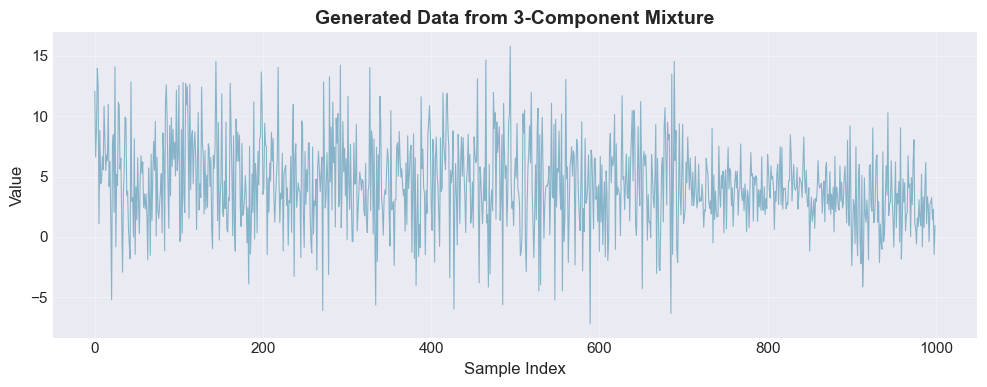

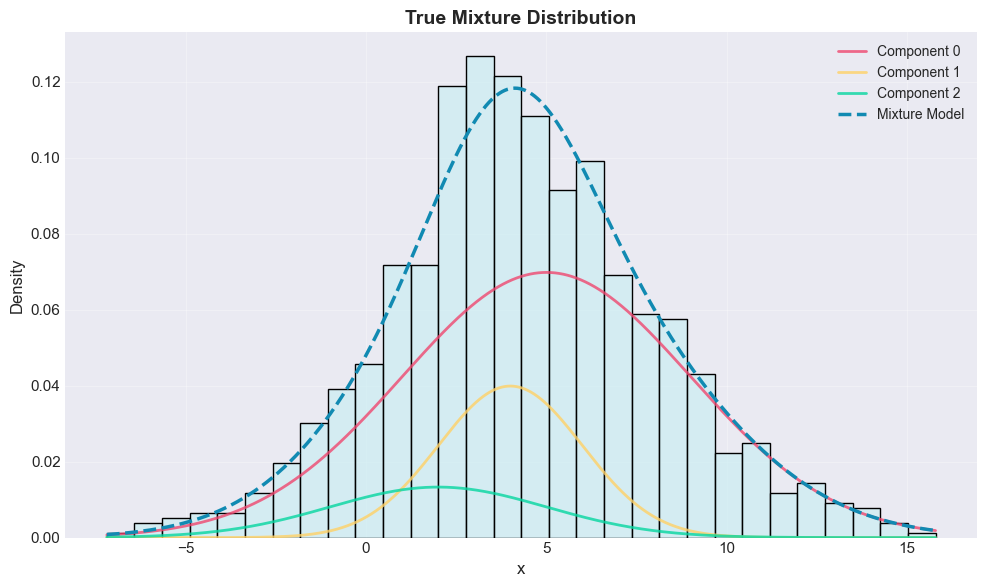

True Model Parameters:
Gaussian Mixture Model (k=3)
  Component 0: weight=0.700, mean=5.0000, std=4.0000
  Component 1: weight=0.200, mean=4.0000, std=2.0000
  Component 2: weight=0.100, mean=2.0000, std=3.0000
Log-likelihood: -2707.2984


In [17]:
# Define true parameters for synthetic data
real_means = np.array([5, 4, 2])
real_std_devs = np.array([4, 2, 3])
real_weights = np.array([0.7, 0.2, 0.1])

# Create the true mixture model
real_gaussian_mixture = GaussianMixture_self(3, real_means, real_std_devs, real_weights)

# Generate 1000 samples from this mixture
analyzer = GaussianMixtureAnalyzer()
analyzer.generate_data_from_gaussian_mixture(real_gaussian_mixture, 1000)

# Visualize the generated data
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(analyzer.data, color="#468faf", alpha=0.6, linewidth=0.8)
ax.set_title("Generated Data from 3-Component Mixture", fontsize=14, fontweight='bold')
ax.set_xlabel("Sample Index", fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show the true distribution
real_gaussian_mixture.set_data(analyzer.data)
real_gaussian_mixture.compute_log_likelihood()
real_gaussian_mixture.plot("True Mixture Distribution")
print("True Model Parameters:")
print(real_gaussian_mixture)

Testing different initialization strategies...



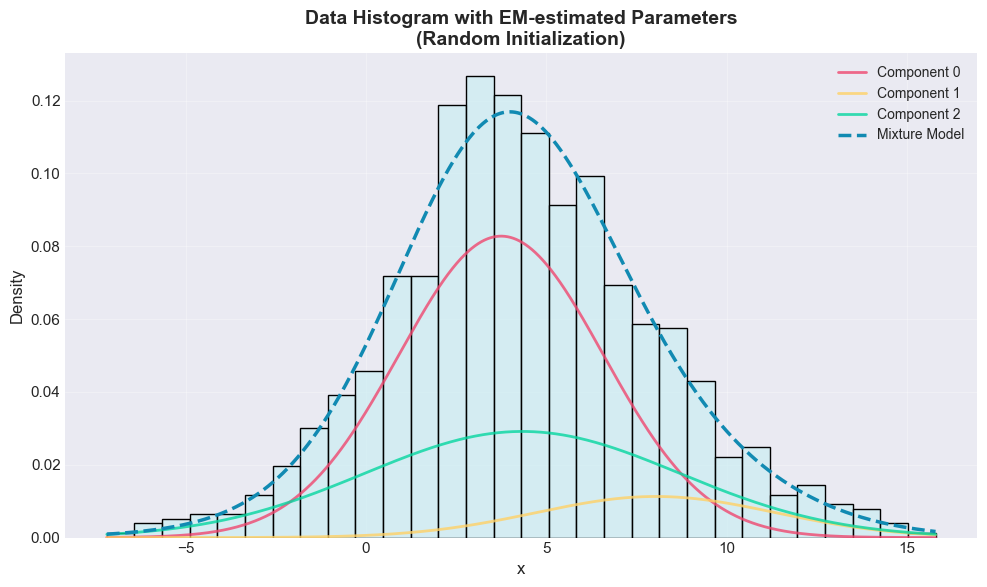

==== EM Algorithm with Random Initialization ====
Gaussian Mixture Model (k=3)
  Component 0: weight=0.588, mean=3.7443, std=2.8329
  Component 2: weight=0.318, mean=4.3281, std=4.3564
  Component 1: weight=0.094, mean=8.0317, std=3.3213
Log-likelihood: -2707.1004


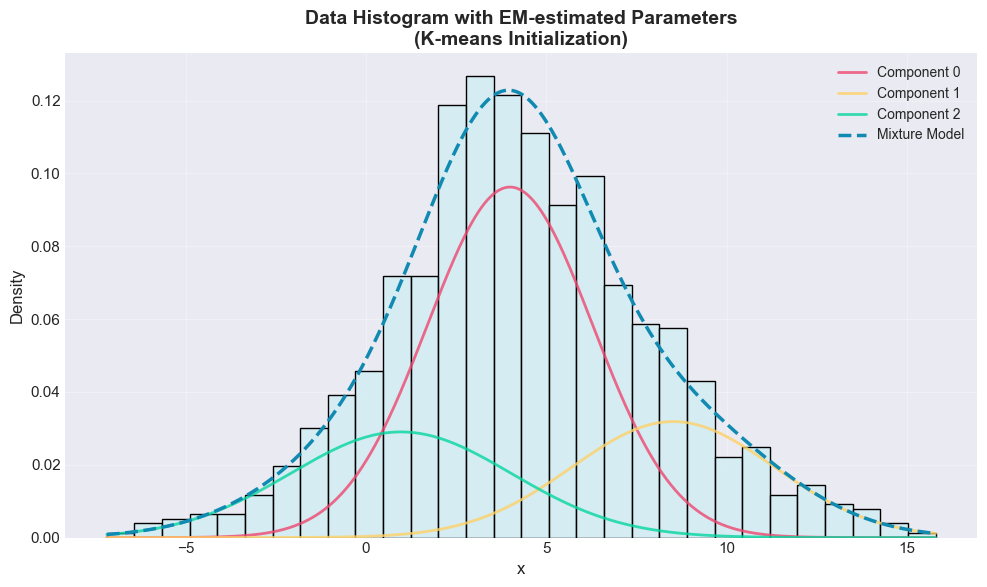

==== EM Algorithm with K-means Initialization ====
Gaussian Mixture Model (k=3)
  Component 0: weight=0.553, mean=3.9916, std=2.2901
  Component 1: weight=0.225, mean=8.5129, std=2.8132
  Component 2: weight=0.223, mean=0.9661, std=3.0639
Log-likelihood: -2705.1242


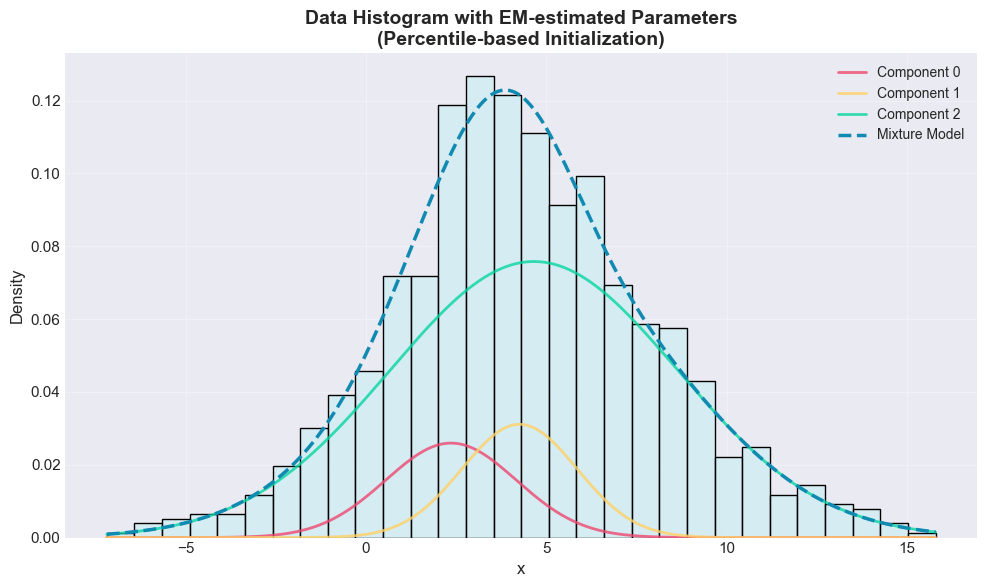

==== EM Algorithm with Percentile Initialization ====
Gaussian Mixture Model (k=3)
  Component 2: weight=0.757, mean=4.6543, std=3.9862
  Component 1: weight=0.125, mean=4.2535, std=1.5974
  Component 0: weight=0.118, mean=2.3547, std=1.8149
Log-likelihood: -2705.7292


{'gaussian_mixture': GaussianMixture(
   [0] weight=0.118, mean=2.3547, std=1.8149
   [1] weight=0.125, mean=4.2535, std=1.5974
   [2] weight=0.757, mean=4.6543, std=3.9862
 ),
 'log-likelihood': np.float64(-2705.1241817535815),
 'bic': np.float64(5465.51040573902)}

In [18]:
# Test all initialization methods with k=3
print("Testing different initialization strategies...\n")
analyzer.analyze_with_given_k(3, verbose=True)

### Comparison with scikit-learn Implementation


VALIDATION: scikit-learn GaussianMixture



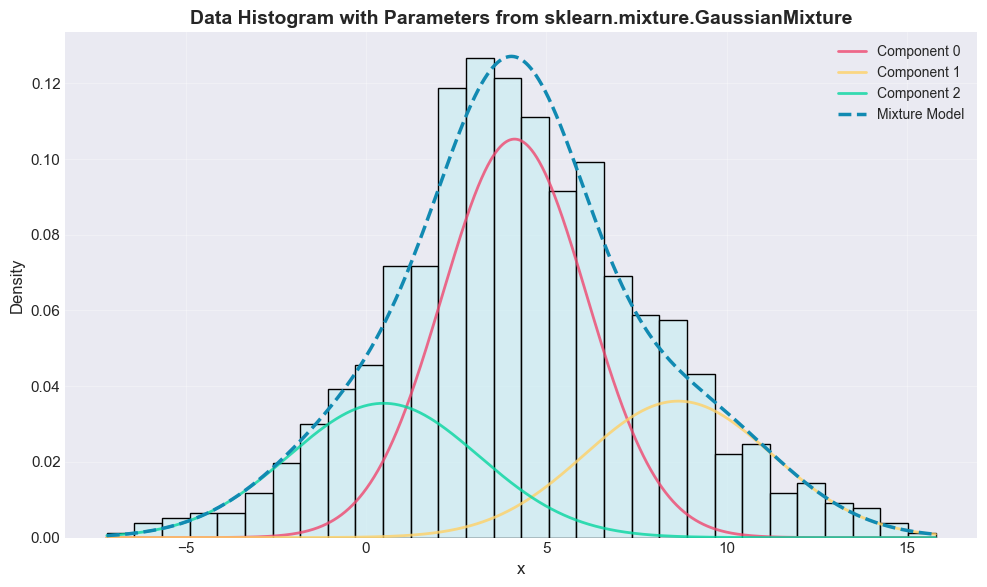

==== sklearn.mixture.GaussianMixture ====
Gaussian Mixture Model (k=3)
  Component 0: weight=0.529, mean=4.1154, std=2.0057
  Component 1: weight=0.236, mean=8.6564, std=2.6088
  Component 2: weight=0.235, mean=0.4883, std=2.6440
Log-likelihood: -2707.4708


In [19]:
# Validate against scikit-learn
print("\n" + "="*60)
print("VALIDATION: scikit-learn GaussianMixture")
print("="*60 + "\n")
analyzer.analyze_sklearn(3, verbose=True)

## Example 2: Automatic Model Selection with BIC

When the true number of components is unknown, we can use BIC to select the optimal k. Let's test this on a 4-component mixture:

Performing BIC analysis to determine optimal number of components...

Running BIC analysis for k = 1 to 7...
k=1: BIC=3791.69
k=2: BIC=3732.87
k=3: BIC=3751.90
k=4: BIC=3771.09
k=5: BIC=3790.57
k=6: BIC=3810.50
k=7: BIC=3828.36

Optimal number of components: k = 2
Minimum BIC: 3732.87


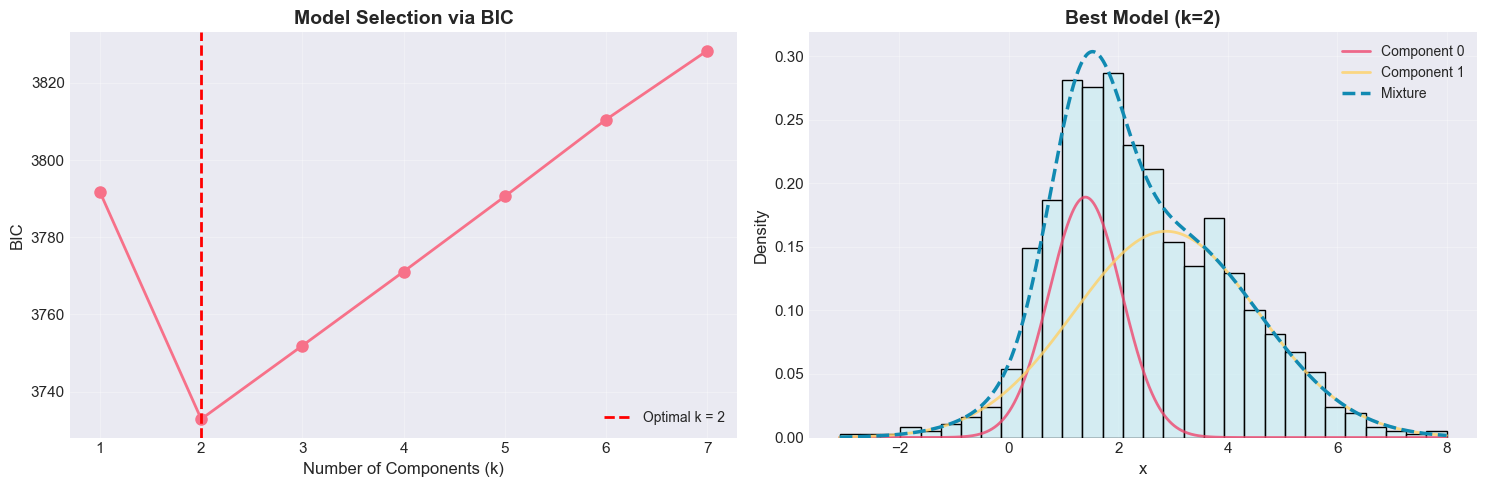


Gaussian Mixture Model (k=2)
  Component 1: weight=0.687, mean=2.8718, std=1.6874
  Component 0: weight=0.313, mean=1.3968, std=0.6606
Log-likelihood: -1849.1632


In [20]:
# Generate data from a 4-component mixture
real_gaussian_mixture_2 = GaussianMixture_self(
    4, 
    [1, 2, 3, 4], 
    [0.5, 0.7, 2, 1], 
    [0.2, 0.3, 0.3, 0.2]
)

analyzer.generate_data_from_gaussian_mixture(real_gaussian_mixture_2, 1000)

# Use BIC to automatically determine optimal k
print("Performing BIC analysis to determine optimal number of components...\n")
analyzer.BIC_analyse(min_k=1, max_k=8, verbose=True)

## Application: Foreign Exchange Trading Volume Analysis

### Dataset 1: SGD-JPY Currency Pair

Analyzing the distribution of trading volumes (log-transformed) for the Singapore Dollar to Japanese Yen exchange rate. GMMs can reveal different trading regimes or market conditions.

Analyzing 1432 trading volume observations...
Value range: [1.10, 7.84]
Running BIC analysis for k = 1 to 6...
k=1: BIC=4200.17
k=2: BIC=4223.07
k=3: BIC=4238.02
k=4: BIC=4260.59
k=5: BIC=4280.66
k=6: BIC=4299.10

Optimal number of components: k = 1
Minimum BIC: 4200.17


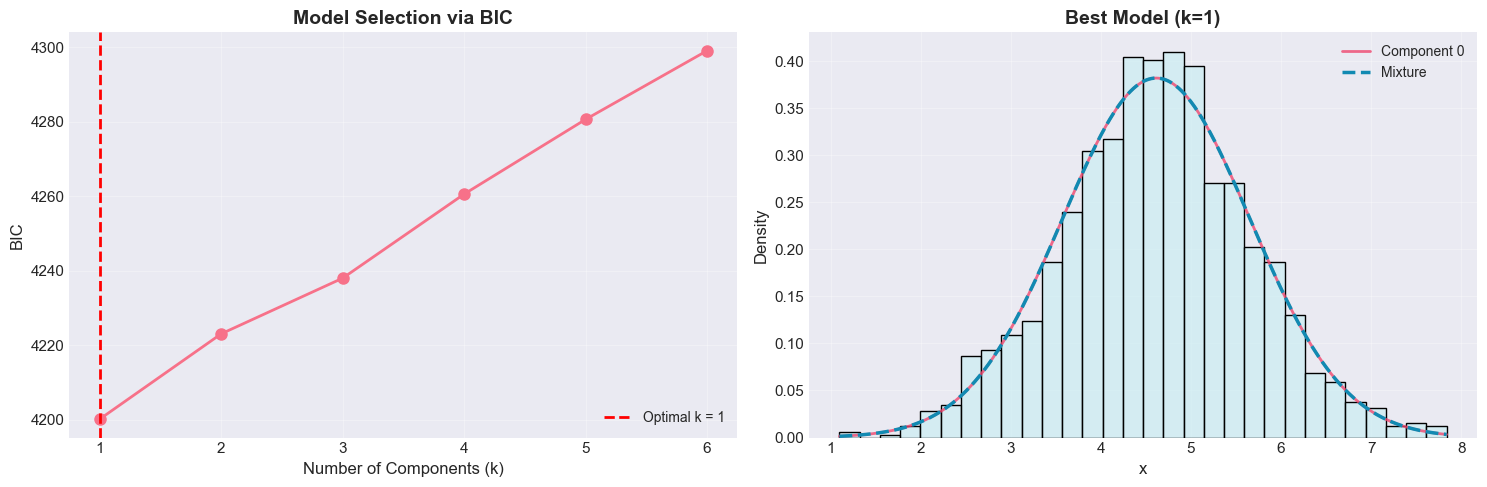


Gaussian Mixture Model (k=1)
  Component 0: weight=1.000, mean=4.6134, std=1.0434
Log-likelihood: -2092.8173


In [21]:
# Load SGD-JPY forex data
df = pd.read_csv("files/SGD-JPY_Minute_2025-12-16_UTC.csv", delimiter=',', header=0)

# Extract non-zero volumes and apply log transformation
volume = df.loc[df["Volume"] > 0, "Volume"]
volume = np.log(volume)

print(f"Analyzing {len(volume)} trading volume observations...")
print(f"Value range: [{volume.min():.2f}, {volume.max():.2f}]")

# Fit GMM and determine optimal components
analyzer.set_data(volume.to_numpy())
analyzer.BIC_analyse(min_k=1, max_k=7, verbose=True)

### Dataset 2: USD-CZK Currency Pair

Analyzing US Dollar to Czech Koruna trading volumes:

Analyzing 1435 trading volume observations...
Value range: [0.18, 7.17]
Running BIC analysis for k = 1 to 6...
k=1: BIC=4962.39
k=2: BIC=4913.50
k=3: BIC=4931.71
k=4: BIC=4949.69
k=5: BIC=4961.86
k=6: BIC=4982.27

Optimal number of components: k = 2
Minimum BIC: 4913.50


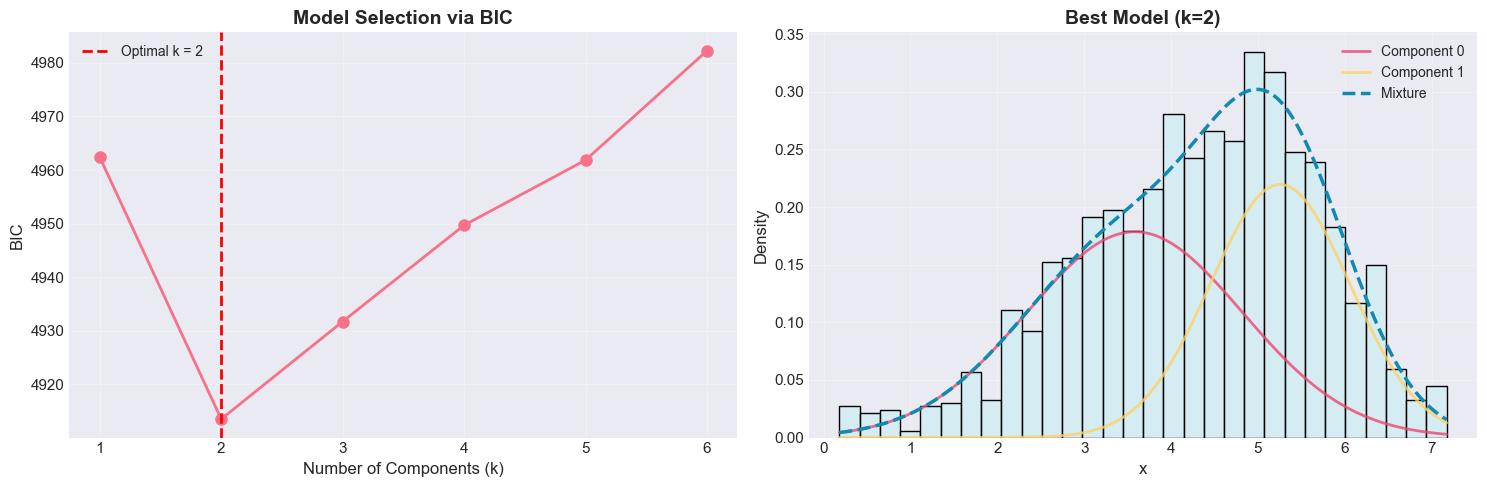


Gaussian Mixture Model (k=2)
  Component 0: weight=0.557, mean=3.5816, std=1.2447
  Component 1: weight=0.443, mean=5.2552, std=0.8041
Log-likelihood: -2438.5769


In [22]:
# Load USD-CZK forex data
df = pd.read_csv("files/USD-CZK_Minute_2025-12-16_UTC.csv", delimiter=',', header=0)

# Extract non-zero volumes and apply log transformation
volume = df.loc[df["Volume"] > 0, "Volume"]
volume = np.log(volume)

print(f"Analyzing {len(volume)} trading volume observations...")
print(f"Value range: [{volume.min():.2f}, {volume.max():.2f}]")

# Fit GMM and determine optimal components
analyzer.set_data(volume.to_numpy())
analyzer.BIC_analyse(min_k=1, max_k=7, verbose=True)

# Conclusions and Key Findings

## Implementation Achievements

1. **Complete EM Algorithm**: Successfully implemented the full EM algorithm from scratch, demonstrating understanding of:
   - Expectation step (responsibility calculation)
   - Maximization step (parameter updates)
   - Log-likelihood computation
   - Convergence criteria

2. **Robust Initialization**: Implemented three different initialization strategies to handle the local optimum problem inherent in EM:
   - Random initialization
   - K-means based (often most stable)
   - Percentile-based (good for separated modes)

3. **Model Selection**: Implemented BIC criterion for automatic determination of optimal number of components, balancing model fit with complexity

## Validation

- Results closely match scikit-learn's implementation, validating correctness
- Successfully recovered true parameters from synthetic data
- Demonstrated practical application on real financial time series

## Applications

The implementation was applied to:
- **Synthetic data**: Verified algorithm correctness and parameter recovery
- **Financial data**: Analyzed forex trading volume distributions, revealing multiple trading regimes

## Technical Skills Demonstrated

- **Statistical modeling**: GMM theory, EM algorithm, model selection
- **Algorithm implementation**: Translating mathematical formulas into efficient code
- **Software engineering**: Object-oriented design, code organization, documentation
- **Data analysis**: Real-world data processing, visualization, interpretation

## Future Enhancements

Potential extensions for this work:
- Multivariate GMM (full covariance matrices)
- Robust estimation (M-estimation, trimmed likelihood)
- Streaming/online EM for large datasets
- Integration with probabilistic programming frameworks
- Application to clustering and anomaly detection tasks

---

**Author**: Portfolio Project  
**Tools**: Python, NumPy, scikit-learn, Matplotlib, Seaborn  
**Concepts**: Expectation-Maximization, Gaussian Mixture Models, Bayesian Information Criterion, Statistical Inference